# Analisis Sentimen Game Mobile Legends

## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
import string

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download as nltk_download
nltk_download('punkt')
nltk_download('stopwords')
nltk_download('wordnet')

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, Bidirectional, MaxPooling1D, Flatten, GRU, SimpleRNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import requests
import csv
from io import StringIO
import tensorflow as tf

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load Dataset

In [2]:
# Memuat data ulasan dari file CSV
csv_file_path = '/content/drive/MyDrive/dataset (1)/mobile_legends1.csv'
df = pd.read_csv(csv_file_path)

# Menampilkan informasi ringkas tentang DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              30000 non-null  object
 1   userName              30000 non-null  object
 2   userImage             30000 non-null  object
 3   content               30000 non-null  object
 4   score                 30000 non-null  int64 
 5   thumbsUpCount         30000 non-null  int64 
 6   reviewCreatedVersion  27750 non-null  object
 7   at                    30000 non-null  object
 8   replyContent          1333 non-null   object
 9   repliedAt             1333 non-null   object
 10  appVersion            27750 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.5+ MB


## Preprocessing Data

In [3]:
# Menghapus missing value pada kolom 'content'
clean_data = df.dropna(subset=['content'])

# Menghapus data duplikat
clean_data = clean_data.drop_duplicates()

In [4]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              30000 non-null  object
 1   userName              30000 non-null  object
 2   userImage             30000 non-null  object
 3   content               30000 non-null  object
 4   score                 30000 non-null  int64 
 5   thumbsUpCount         30000 non-null  int64 
 6   reviewCreatedVersion  27750 non-null  object
 7   at                    30000 non-null  object
 8   replyContent          1333 non-null   object
 9   repliedAt             1333 non-null   object
 10  appVersion            27750 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.5+ MB


In [5]:
# Mendefinisikan fungsi-fungsi untuk preprocessing text

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'[^\w\s]', '', text) # remove numbers
    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text):
    text = text.lower()
    return text

def tokenizingText(text):
    text = word_tokenize(text)
    return text

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    words = text.split()

    stemmed_words = [stemmer.stem(word) for word in words]

    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [6]:
# Mendefinisikan fungsi untuk slangwords

slangwords = {"@": "di", "yg": "yang",
    "gk": "tidak",
    "gak": "tidak",
    "ga": "tidak",
    "aja": "saja",
    "nggak": "tidak",
    "ngga": "tidak",
    "klo": "kalau",
    "kl": "kalau",
    "tdk": "tidak",
    "dgn": "dengan",
    "bgt": "banget",
    "bkin": "bikin",
    "bgtu": "begitu",
    "bbrp": "beberapa",
    "udh": "sudah",
    "dr": "dari",
    "tp": "tapi",
    "krn": "karena",
    "sm": "sama",
    "dl": "dulu",
    "blm": "belum",
    "trs": "terus",
    "sy": "saya",
    "lg": "lagi",
    "dlu": "dulu",
    "td": "tadi",
    "jd": "jadi",
    "jg": "juga",
    "btw": "ngomong-ngomong",
    "cmn": "cuman",
    "cuma": "hanya",
    "bgt": "banget",
    "ml": "mobile legends",
    "maen": "main",
    "mainin": "main",
    "bales": "balas",
    "bakal": "akan",
    "makasih": "terima kasih",
    "makasi": "terima kasih",
    "makasii": "terima kasih",
    "makasiii": "terima kasih"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [7]:
# Menampilkan dataset yang belum dibersihkan
clean_df = clean_data
clean_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,9bd15e3b-7ae1-4827-af1c-f80b9aea4fa2,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,tiap main rank pasti aja ada player beban/male...,1,17561,1.9.65.10602,2025-03-28 15:42:15,NaN,NaN,1.9.65.10602
1,04893854-ffc4-4a5a-bd53-18dda4879354,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,jika setiap update game rank nya selalu saja m...,2,547,1.9.65.10602,2025-03-30 16:27:41,NaN,NaN,1.9.65.10602
2,32d316bf-a701-4017-9746-8c3b71dc0892,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Bintang 3 aja moonton, grafik sudah oke, efek ...",3,1430,1.9.65.10602,2025-03-29 18:36:17,"Halo Kak,\nKami berkomitmen untuk menciptakan ...",2025-01-04 04:00:00,1.9.65.10602
3,b541e597-ea22-4560-a4c2-a46643e719e1,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,kemarin install lagi ini game dengan harapan s...,1,550,1.9.65.10602,2025-03-28 23:50:06,NaN,NaN,1.9.65.10602
4,45f19d76-0bd1-4469-8cc8-ddfb1ecc7896,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"untuk gamenya sudah bagus, banyak skin dan fit...",3,22,1.9.65.10602,2025-04-10 06:11:59,NaN,NaN,1.9.65.10602


In [8]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

In [9]:
clean_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,9bd15e3b-7ae1-4827-af1c-f80b9aea4fa2,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,tiap main rank pasti aja ada player beban/male...,1,17561,1.9.65.10602,2025-03-28 15:42:15,NaN,NaN,1.9.65.10602,tiap main rank pasti aja ada player bebanmales...,tiap main rank pasti aja ada player bebanmales...,tiap main rank pasti saja ada player bebanmale...,"[tiap, main, rank, pasti, saja, ada, player, b...","[main, rank, player, bebanmales, main, player,...",main rank player bebanmales main player pengal...
1,04893854-ffc4-4a5a-bd53-18dda4879354,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,jika setiap update game rank nya selalu saja m...,2,547,1.9.65.10602,2025-03-30 16:27:41,NaN,NaN,1.9.65.10602,jika setiap update game rank nya selalu saja m...,jika setiap update game rank nya selalu saja m...,jika setiap update game rank nya selalu saja m...,"[jika, setiap, update, game, rank, nya, selalu...","[update, game, rank, mengurang, capek, menyele...",update game rank mengurang capek menyelesaikan...
2,32d316bf-a701-4017-9746-8c3b71dc0892,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Bintang 3 aja moonton, grafik sudah oke, efek ...",3,1430,1.9.65.10602,2025-03-29 18:36:17,"Halo Kak,\nKami berkomitmen untuk menciptakan ...",2025-01-04 04:00:00,1.9.65.10602,Bintang aja moonton grafik sudah oke efek vis...,bintang aja moonton grafik sudah oke efek vis...,bintang saja moonton grafik sudah oke efek vis...,"[bintang, saja, moonton, grafik, sudah, oke, e...","[bintang, moonton, grafik, oke, efek, visual, ...",bintang moonton grafik oke efek visual skill p...
3,b541e597-ea22-4560-a4c2-a46643e719e1,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,kemarin install lagi ini game dengan harapan s...,1,550,1.9.65.10602,2025-03-28 23:50:06,NaN,NaN,1.9.65.10602,kemarin install lagi ini game dengan harapan s...,kemarin install lagi ini game dengan harapan s...,kemarin install lagi ini game dengan harapan s...,"[kemarin, install, lagi, ini, game, dengan, ha...","[kemarin, install, game, harapan, semoga, gitu...",kemarin install game harapan semoga gitu kenda...
4,45f19d76-0bd1-4469-8cc8-ddfb1ecc7896,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"untuk gamenya sudah bagus, banyak skin dan fit...",3,22,1.9.65.10602,2025-04-10 06:11:59,NaN,NaN,1.9.65.10602,untuk gamenya sudah bagus banyak skin dan fitu...,untuk gamenya sudah bagus banyak skin dan fitu...,untuk gamenya sudah bagus banyak skin dan fitu...,"[untuk, gamenya, sudah, bagus, banyak, skin, d...","[gamenya, bagus, skin, fitur, fitur, menarik, ...",gamenya bagus skin fitur fitur menarik game bu...


In [10]:
# Loads positive lexicon data from GitHub
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
reader = csv.reader(StringIO(response.text), delimiter=',')
for row in reader:
    lexicon_positive[row[0]] = int(row[1])


# Loads negative lexicon data from GitHub
# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
reader = csv.reader(StringIO(response.text), delimiter=',')
for row in reader:
    lexicon_negative[row[0]] = int(row[1])

In [11]:
# Fungsi untuk menentukan polaritas sentimen dari tweet

def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen

    polarity=''

    if (score >= 0):
        polarity = 'positive'
    elif (score <= -7):
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

## Labelling Data

In [12]:
# Memberi label pada text
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
negative    11472
positive    10256
neutral      8272
Name: count, dtype: int64


## Menampilkan Distribusi

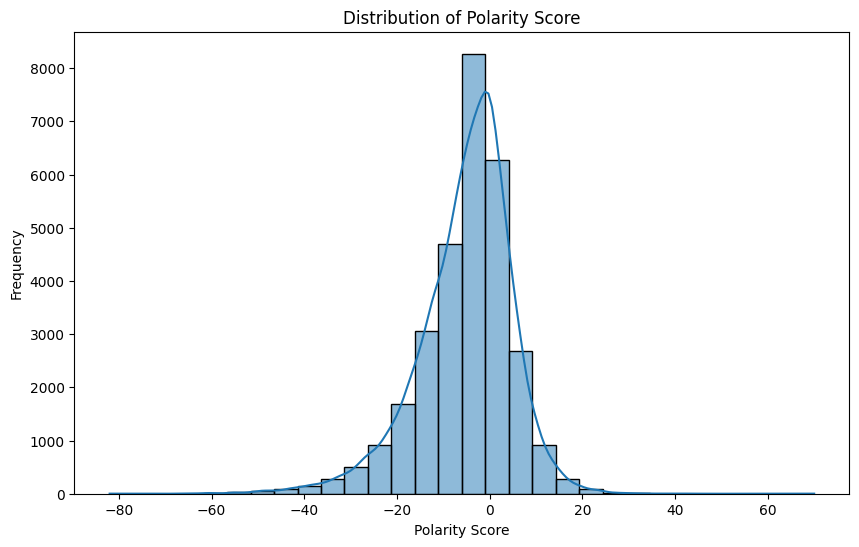

In [13]:
# Menampilkan distribusi polarity_score dengan histogram
plt.figure(figsize=(10, 6))
sns.histplot(clean_df['polarity_score'], bins=30, kde=True)
plt.title('Distribution of Polarity Score')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.show()

## MEnghitung Polaritas

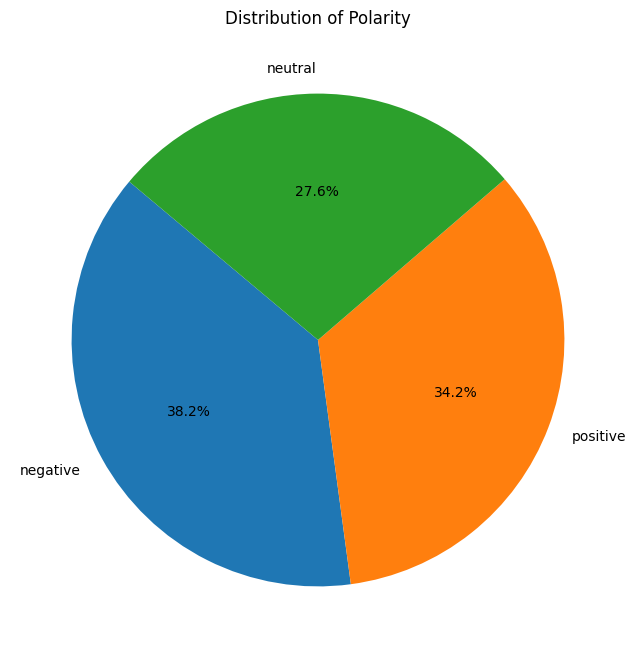

In [14]:
# Hitung jumlah masing-masing kategori polaritas
polarity_counts = clean_df['polarity'].value_counts()

# Menampilkan diagram lingkaran
plt.figure(figsize=(8, 8))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Polarity')
plt.show()

## Wordcloud Umum

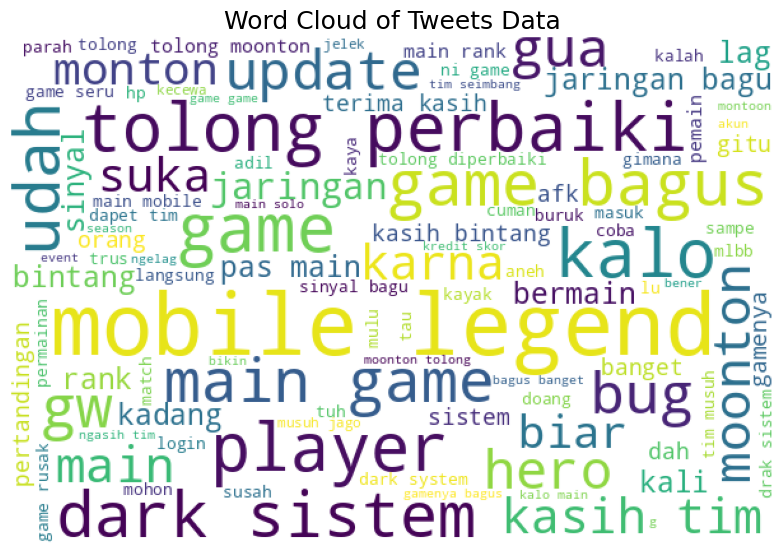

In [15]:
# Membuat wordcloud secara umum

list_words = ''

for tweet in clean_df['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

In [16]:
# Membuat dataframe untuk wordcloud positive
pd.set_option('display.max_colwidth', 3000)

positive_tweets = clean_df[clean_df['polarity'] == 'positive']
positive_tweets = positive_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
positive_tweets = positive_tweets.sort_values(by='polarity_score', ascending=False)
positive_tweets = positive_tweets.reset_index(drop=True)
positive_tweets.index += 1

## Wordcloud Data Positif

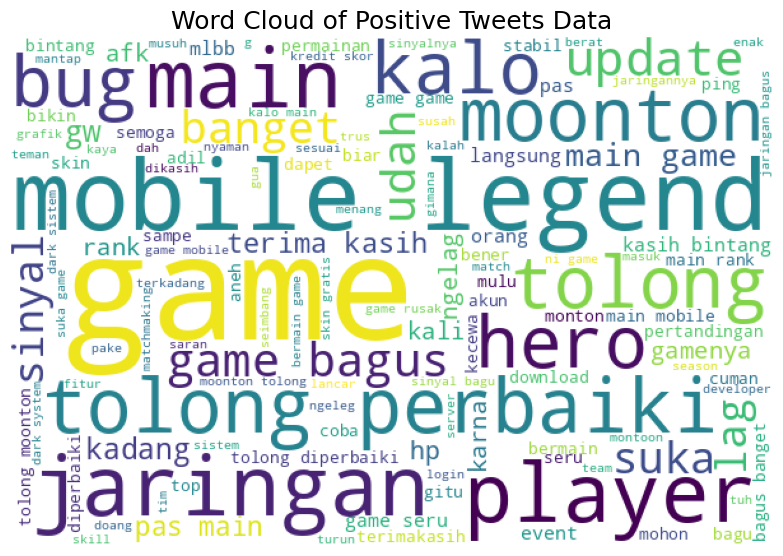

In [17]:
# Menampilkan wordcloud untuk label positive
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'positive_tweets'.
for tweet in positive_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Positive Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

## Wordcloud Data Negatif

In [18]:
# Membuat dataframe untuk wordcloud negative
pd.set_option('display.max_colwidth', 3000)

negative_tweets = clean_df[clean_df['polarity'] == 'negative']
negative_tweets = negative_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
negative_tweets = negative_tweets.sort_values(by='polarity_score', ascending=False)
negative_tweets = negative_tweets.reset_index(drop=True)
negative_tweets.index += 1

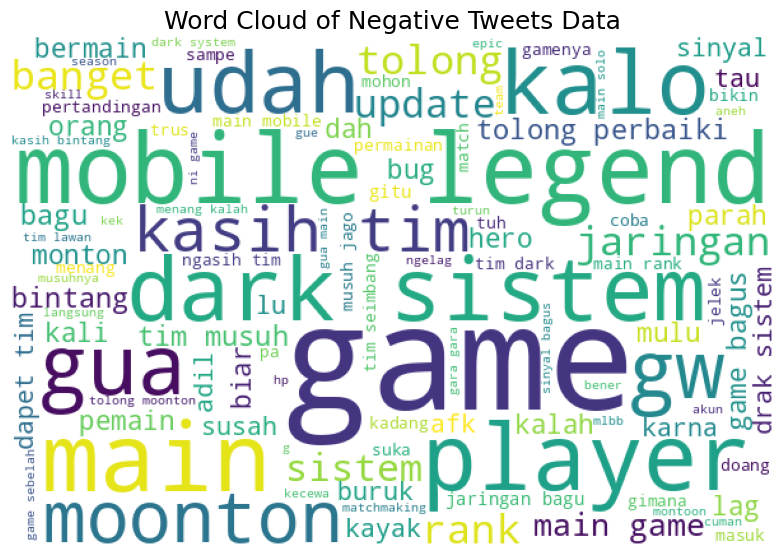

In [19]:
# Menampilkan wordcloud untuk label negative
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'negative_tweets'.
for tweet in negative_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Negative Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

## Wordcloud Data Netral

In [20]:
# Membuat dataframe untuk wordcloud neutral
pd.set_option('display.max_colwidth', 3000)

neutral_tweets = clean_df[clean_df['polarity'] == 'neutral']
neutral_tweets = neutral_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
neutral_tweets = neutral_tweets.sort_values(by='polarity_score', ascending=False)
neutral_tweets = neutral_tweets.reset_index(drop=True)
neutral_tweets.index += 1

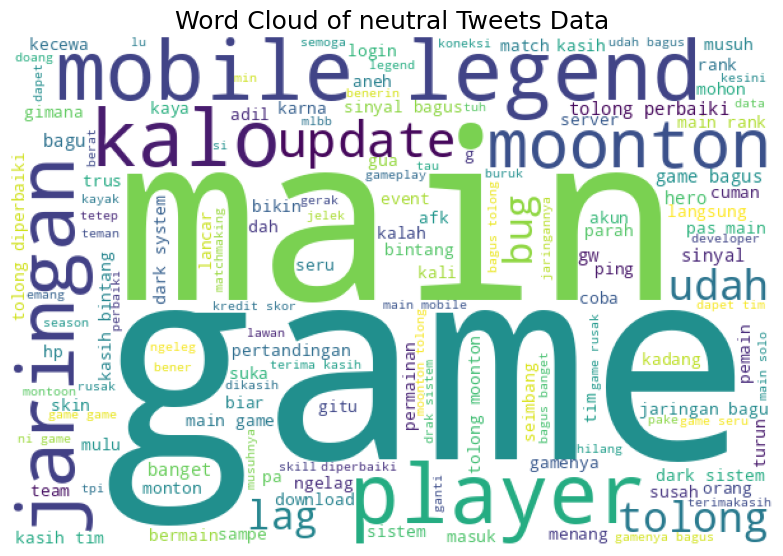

In [21]:
# Menampilkan wordcloud untuk label neutral
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'neutral_tweets'.
for tweet in neutral_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of neutral Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

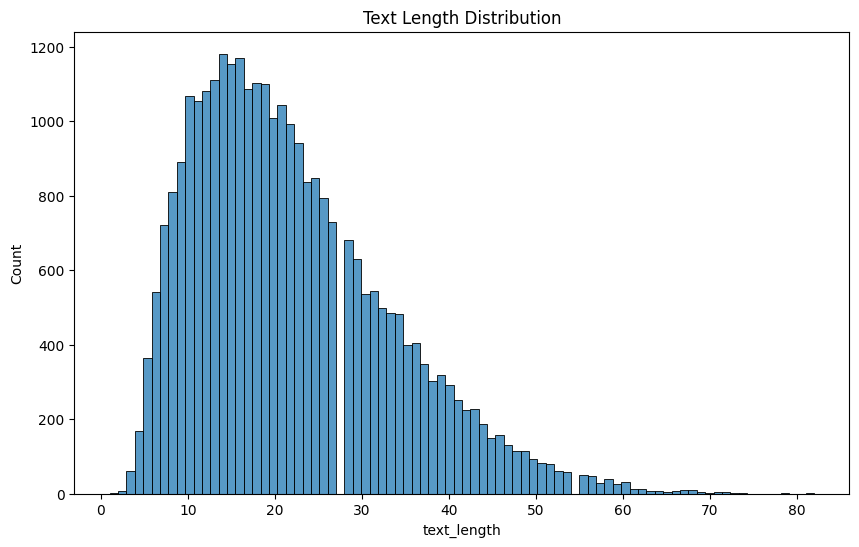

In [22]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Visualize text length distribution
clean_df['text_length'] = clean_df['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(clean_df['text_length'])
plt.title('Text Length Distribution')
plt.show()

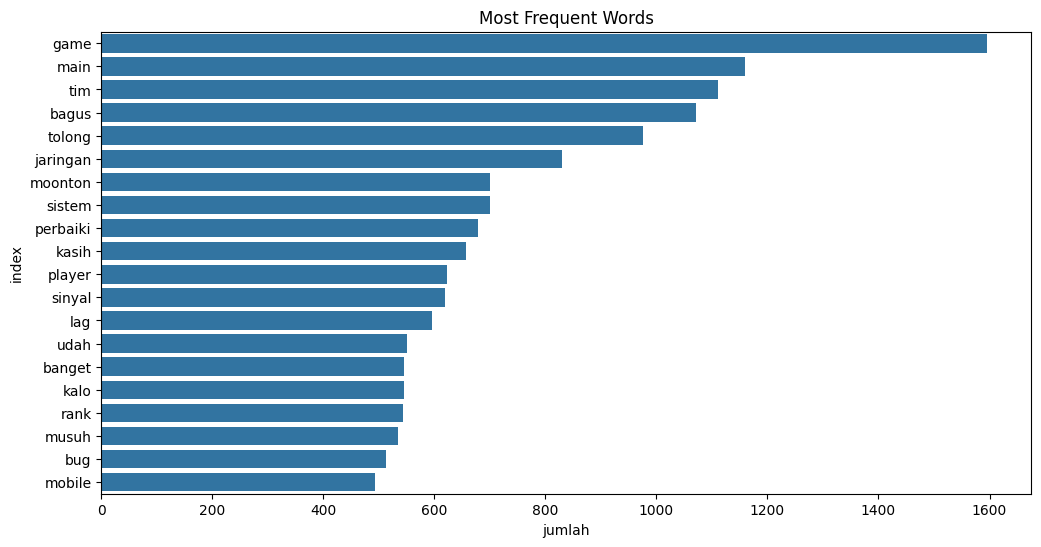

In [23]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Visualize most frequent words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_df['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

In [24]:
# Mengambil kolom text_akhir dan polarity
X = clean_df['text_akhir']
y = clean_df['polarity']

## Tokenisasi

In [25]:
# Tokenisasi
max_features = 2500
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X)

# Label encoding
labelencoder = LabelEncoder()
integer_encoded = labelencoder.fit_transform(y)
y = to_categorical(integer_encoded)

# Menentukan jumlah kelas
num_classes = y.shape[1]

In [26]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > 0.92:
            print(f"\nVal accuracy telah melebihi 0.92, menghentikan pelatihan pada epoch {epoch+1}")
            self.model.stop_training = True
early_stopping = CustomCallback()

In [27]:
# Memisahkan data latih, validasi, dan uji
X_train_val, X_test_LSTM, y_train_val, y_test_LSTM = train_test_split(X, y, test_size=0.1, random_state=42)

X_train_LSTM, X_val_LSTM, y_train_LSTM, y_val_LSTM = train_test_split(X_train_val, y_train_val, test_size=2/9, random_state=42)

## Model LSTM

In [28]:
# Membangun model LSTM
model_LSTM = Sequential()
model_LSTM.add(Embedding(max_features, 256, input_length=X.shape[1]))
model_LSTM.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01), return_sequences=True))
model_LSTM.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))
model_LSTM.add(Dense(128, activation='relu'))
model_LSTM.add(Dense(64, activation='relu'))
model_LSTM.add(Dense(num_classes, activation='softmax'))
model_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Melatih model dengan early stopping kustom
batch_size = 2056
history_LSTM = model_LSTM.fit(X_train_LSTM, y_train_LSTM, epochs=50, batch_size=batch_size, verbose=2, callbacks=[early_stopping], validation_data=(X_val_LSTM, y_val_LSTM))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 - 101s - 9s/step - accuracy: 0.4614 - loss: 5.5084 - val_accuracy: 0.5187 - val_loss: 4.5787
Epoch 2/50
11/11 - 134s - 12s/step - accuracy: 0.5661 - loss: 4.0035 - val_accuracy: 0.5590 - val_loss: 3.3710
Epoch 3/50
11/11 - 141s - 13s/step - accuracy: 0.6234 - loss: 2.9333 - val_accuracy: 0.6703 - val_loss: 2.4161
Epoch 4/50
11/11 - 137s - 12s/step - accuracy: 0.7062 - loss: 2.1114 - val_accuracy: 0.7225 - val_loss: 1.7703
Epoch 5/50
11/11 - 87s - 8s/step - accuracy: 0.7627 - loss: 1.5347 - val_accuracy: 0.7758 - val_loss: 1.3131
Epoch 6/50
11/11 - 142s - 13s/step - accuracy: 0.7137 - loss: 1.3215 - val_accuracy: 0.6080 - val_loss: 1.3572
Epoch 7/50
11/11 - 141s - 13s/step - accuracy: 0.6783 - loss: 1.1723 - val_accuracy: 0.6867 - val_loss: 1.0894
Epoch 8/50
11/11 - 141s - 13s/step - accuracy: 0.7349 - loss: 0.9659 - val_accuracy: 0.7488 - val_loss: 0.8864
Epoch 9/50
11/11 - 83s - 8s/step - accuracy: 0.7807 - loss: 0.7718 - val_accuracy: 0.7843 - val_loss: 0.7214
Epoch 10/50
11/11

In [29]:
# Evaluasi model
score_LSTM, acc_LSTM = model_LSTM.evaluate(X_test_LSTM, y_test_LSTM, verbose=2)
print("Test score: %.2f" % (score_LSTM))
print("Test accuracy: %.2f" % (acc_LSTM))

94/94 - 5s - 53ms/step - accuracy: 0.8667 - loss: 0.4488
Test score: 0.45
Test accuracy: 0.87


In [30]:
model_LSTM.save('model_LSTM.h5')

## Model CNN

In [31]:
# Memisahkan data latih, validasi, dan uji
X_train_val, X_test_CNN, y_train_val, y_test_CNN = train_test_split(X, y, test_size=0.1, random_state=42)

X_train_CNN, X_val_CNN, y_train_CNN, y_val_CNN = train_test_split(X_train_val, y_train_val, test_size=1/9, random_state=42)

In [32]:
# Membangun model CNN
model_CNN = Sequential()
model_CNN.add(Embedding(max_features, 512, input_length=X.shape[1]))
model_CNN.add(Conv1D(64, kernel_size=5, activation='relu'))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Flatten())
model_CNN.add(Dense(64, activation='relu'))
model_CNN.add(Dropout(0.5))
model_CNN.add(Dense(num_classes, activation='softmax'))
model_CNN.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Melatih model dengan early stopping kustom
batch_size = 2056
history_CNN = model_CNN.fit(X_train_CNN, y_train_CNN, epochs=50, batch_size=batch_size, verbose=2, callbacks=[early_stopping], validation_data=(X_val_CNN, y_val_CNN))

Epoch 1/50
12/12 - 60s - 5s/step - accuracy: 0.4778 - loss: 1.0244 - val_accuracy: 0.5587 - val_loss: 0.9131
Epoch 2/50
12/12 - 57s - 5s/step - accuracy: 0.6327 - loss: 0.8079 - val_accuracy: 0.6887 - val_loss: 0.6938
Epoch 3/50
12/12 - 84s - 7s/step - accuracy: 0.7287 - loss: 0.6180 - val_accuracy: 0.7593 - val_loss: 0.5654
Epoch 4/50
12/12 - 80s - 7s/step - accuracy: 0.7932 - loss: 0.4984 - val_accuracy: 0.7790 - val_loss: 0.5116
Epoch 5/50
12/12 - 82s - 7s/step - accuracy: 0.8223 - loss: 0.4319 - val_accuracy: 0.7920 - val_loss: 0.4852
Epoch 6/50
12/12 - 81s - 7s/step - accuracy: 0.8469 - loss: 0.3914 - val_accuracy: 0.7990 - val_loss: 0.4805
Epoch 7/50
12/12 - 57s - 5s/step - accuracy: 0.8587 - loss: 0.3664 - val_accuracy: 0.8030 - val_loss: 0.4870
Epoch 8/50
12/12 - 82s - 7s/step - accuracy: 0.8730 - loss: 0.3440 - val_accuracy: 0.8023 - val_loss: 0.4891
Epoch 9/50
12/12 - 83s - 7s/step - accuracy: 0.8840 - loss: 0.3188 - val_accuracy: 0.7980 - val_loss: 0.5000
Epoch 10/50
12/12 -

In [33]:
# Evaluasi model
score_CNN, acc_CNN = model_CNN.evaluate(X_test_CNN, y_test_CNN, verbose=2,batch_size=1028)
print("Test score: %.2f" % (score_CNN))
print("Test accuracy: %.2f" % (acc_CNN))

3/3 - 2s - 543ms/step - accuracy: 0.7633 - loss: 1.9277
Test score: 1.93
Test accuracy: 0.76


In [34]:
model_CNN.save('model_CNN.h5')

## Model Gru

In [35]:
# Memisahkan data latih, validasi, dan uji
X_train_val, X_test_GRU, y_train_val, y_test_GRU = train_test_split(X, y, test_size=0.05, random_state=42)
X_train_GRU, X_val_GRU, y_train_GRU, y_val_GRU = train_test_split(X_train_val, y_train_val, test_size=0.0526, random_state=42)

In [36]:
# Membangun model GRU
model_GRU = Sequential()
model_GRU.add(Embedding(max_features, 512, input_length=X.shape[1]))
model_GRU.add(SpatialDropout1D(0.3))
model_GRU.add(Bidirectional(GRU(64, return_sequences=True)))
model_GRU.add(Bidirectional(GRU(128, return_sequences=False)))
model_GRU.add(Dense(128, activation='relu',kernel_regularizer=l2(0.01)))
model_GRU.add(Dropout(0.5))
model_GRU.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_GRU.add(Dropout(0.5))
model_GRU.add(Dense(num_classes, activation='softmax'))
model_GRU.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Melatih model dengan early stopping kustom
batch_size = 1028
history_GRU = model_GRU.fit(X_train_GRU, y_train_GRU, epochs=20, batch_size=batch_size, verbose=2, validation_data=(X_val_GRU, y_val_GRU),callbacks=[early_stopping])

Epoch 1/20
27/27 - 204s - 8s/step - accuracy: 0.4829 - loss: 2.9834 - val_accuracy: 0.6527 - val_loss: 2.1515
Epoch 2/20
27/27 - 197s - 7s/step - accuracy: 0.7234 - loss: 1.7105 - val_accuracy: 0.8167 - val_loss: 1.2426
Epoch 3/20
27/27 - 200s - 7s/step - accuracy: 0.8241 - loss: 1.0560 - val_accuracy: 0.7860 - val_loss: 0.9215
Epoch 4/20
27/27 - 186s - 7s/step - accuracy: 0.8625 - loss: 0.7250 - val_accuracy: 0.8500 - val_loss: 0.6521
Epoch 5/20
27/27 - 203s - 8s/step - accuracy: 0.8878 - loss: 0.5345 - val_accuracy: 0.8560 - val_loss: 0.5372
Epoch 6/20
27/27 - 198s - 7s/step - accuracy: 0.8983 - loss: 0.4339 - val_accuracy: 0.8467 - val_loss: 0.5081
Epoch 7/20
27/27 - 186s - 7s/step - accuracy: 0.9052 - loss: 0.3757 - val_accuracy: 0.8600 - val_loss: 0.4539
Epoch 8/20
27/27 - 203s - 8s/step - accuracy: 0.9091 - loss: 0.3413 - val_accuracy: 0.8707 - val_loss: 0.4335
Epoch 9/20
27/27 - 202s - 7s/step - accuracy: 0.9198 - loss: 0.3024 - val_accuracy: 0.8540 - val_loss: 0.4427
Epoch 10/2

In [37]:
# Evaluasi model
score_GRU, acc_GRU = model_GRU.evaluate(X_test_GRU, y_test_GRU, verbose=2)
print("Test score: %.2f" % (score_GRU))
print("Test accuracy: %.2f" % (acc_GRU))

47/47 - 4s - 76ms/step - accuracy: 0.8600 - loss: 0.4711
Test score: 0.47
Test accuracy: 0.86


In [38]:
# Menyimpan model
model_GRU.save('model_GRU.h5')

## Evaluasi Model

In [39]:
results_df = pd.DataFrame({
    'Model': ['LSTM', 'CNN', 'GRU'],
    'Accuracy Train': [history_LSTM.history['accuracy'][-1], history_CNN.history['accuracy'][-1],history_GRU.history['accuracy'][-1]],
    'Accuracy Test': [acc_LSTM, acc_CNN,acc_GRU]
})
results_df

,Model,Accuracy Train,Accuracy Test
0,LSTM,0.939857,0.866667
1,CNN,0.998417,0.763333
2,GRU,0.954778,0.860000


## Prediksi Model

In [42]:
# Contoh data baru
new_texts = [
    "Game-nya seru banget, grafik mantap dan skin baru keren!",
     "game jelek banget",
     "Cuma login sebentar buat klaim reward",
]

# Nilai asli dari teks
true_labels = ["positive", "negative", "neutral"]

# Tokenisasi teks baru
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded_sequences = pad_sequences(new_sequences, maxlen=X.shape[1])

# Membuat prediksi
predictions_LSTM = model_LSTM.predict(new_padded_sequences)
predictions_CNN = model_CNN.predict(new_padded_sequences)
predictions_GRU = model_GRU.predict(new_padded_sequences)

# Mengubah prediksi menjadi label
predicted_labels_LSTM = np.argmax(predictions_LSTM, axis=1)
predicted_labels_CNN = np.argmax(predictions_CNN, axis=1)
predicted_labels_GRU = np.argmax(predictions_GRU, axis=1)

predicted_labels_LSTM = labelencoder.inverse_transform(predicted_labels_LSTM)
predicted_labels_CNN = labelencoder.inverse_transform(predicted_labels_CNN)
predicted_labels_GRU = labelencoder.inverse_transform(predicted_labels_GRU)

# Menampilkan hasil prediksi
for text, true_label, label_LSTM, label_CNN, label_GRU in zip(new_texts, true_labels, predicted_labels_LSTM, predicted_labels_CNN, predicted_labels_GRU):
    print(f"Text: {text}\nTrue Label: {true_label}\nPredicted Label (LSTM): {label_LSTM}\nPredicted Label (CNN): {label_CNN}\nPredicted Label (GRU): {label_GRU}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Text: Game-nya seru banget, grafik mantap dan skin baru keren!
True Label: positive
Predicted Label (LSTM): positive
Predicted Label (CNN): positive
Predicted Label (GRU): positive

Text: game jelek banget
True Label: negative
Predicted Label (LSTM): neutral
Predicted Label (CNN): negative
Predicted Label (GRU): neutral

Text: Cuma login sebentar buat klaim reward
True Label: neutral
Predicted Label (LSTM): neutral
Predicted Label (CNN): neutral
Predicted Label (GRU): neutral

